# SmartCab Report

## Question 1
> Observe what you see with the agent's behavior as it takes random actions. Does the smartcab eventually make it to the destination? Are there any other interesting observations to note?

I haven't seen the smartcab meet the destination taking random actions before the time limit expiring.

The smartcab seems to spent about half its time stopped at intersections rather than moving.

Probability of moving:
Red light -> None, Forward (2/5)
Green light -> None (1/5)
3/10 possibilities at a random light will keep the car stopped. That's definitely smaller than what I observe. There must be something about the orientation of the lights that means the probability of hitting a red light vs. green light is not equal (when you see a red, you see it for many turns, while you pass through a green quickly). That means the algorithm will maybe make right-turns at red lights to get out of them.

## Question 2

> QUESTION: What states have you identified that are appropriate for modeling the smartcab and environment? Why do you believe each of these states to be appropriate for this problem?

This was my code for choosing the state. I combined inputs to make one of 64 possible states:

```
oncoming_blocking_left = inputs['oncoming'] in ['right', 'forward']
if oncoming_blocking_left:
    oncoming = "oncoming blocking left"
elif inputs['oncoming']:
    oncoming = "True"
else:
    oncoming = "False"

left = str(inputs['left'] is None)
right = str(inputs['right'] is None)

# 3 x 3 x 2 x 2 x 2 possibilities = 64 possible states
states = [self.next_waypoint, oncoming, left, right, inputs['light']]

self.state = ','.join(states)
```

I wanted to leave room for the learner to learn the rules, while giving so many states that it would never have a chance to learn them all. I reduced the possible state combinations coming from left, right and oncoming to what is relevant. I had to include the inputs['light'], inputs['oncoming'], inputs['left'], inputs['right'] for provide enough information to always get the same reward when performing an action on a state. If I reduced further for these, either the learner could get different rewards for the same state/action pair, or I would be implicitly encoding the rules into the learner, preventing it from learning the rule.

I didn't include time to destination because since we're not allowed to break the rules of the road and the most efficient route is to always follow the planner, the time to destination will not usefully change actions. It would only multiply states unecessarily. 

If we were allowed to break the rules, I would have enjoyed trying the states "follow the rules" vs. "don't follow the rules" x (time_to_destination - time_remaining) in a larger grid because it would be less obvious what the optimal strategy is.


## Question 3

> OPTIONAL: How many states in total exist for the smartcab in this environment? Does this number seem reasonable given that the goal of Q-Learning is to learn and make informed decisions about each state? Why or why not?

If we don't know how the other agents work or they are random, the number of states is exponentially related to the deadline for the smartcab in this environment. Imagine an input was: `{'light': 'red', 'left': 'forward', ...}`. The next turns state would be "Last turn forward car on left and...", the turn after would be "Two turns ago forward car on left and...". This would have to be combined with every encounter with a car.

This is obviously not reasonable for Q-learning, because the difference between most of the states will be completely negligible and we would at best ignore them, and at worst overfit on them.

## Question 4

> QUESTION: What changes do you notice in the agent's behavior when compared to the basic driving agent when random actions were always taken? Why is this behavior occurring?

The learning agent initially turns left all the time because if all actions have the same expected reward, it defaults to left, and all actions for all states start with the same reward. It quickly learns not to go through red lights when there are no cars around and to go the correct direction on green lights when no cars are around (because it encounters those situations so often, so the expected rewards for actions in those states quickly converge to an approximately correct value).

## Question 5

> QUESTION: Report the different values for the parameters tuned in your basic implementation of Q-Learning. For which set of parameters does the agent perform best? How well does the final driving agent perform?

See the results and graphs below. 

The best results for success rate came at around a learning rate of 0.9 and a discount rate of 0.1. The final driving agent gets 100/100 successes in few best cases and high 90s/100 in many cases (for all trials of learning rates and discount rates in [0.0, 0.1, ..., 1.0].

The best results for average success time (see last graph) came with low discount rates (but greater than 0.1) and high learning rates.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np


# load data
trials = [(0.0, 0.0, 1, 6), (0.0, 0.1, 2, 6), (0.0, 0.2, 2, 3), (0.0, 0.3, 3, 5), (0.0, 0.4, 2, 7), (0.0, 0.5, 1, 8), (0.0, 0.6, 2, 7), (0.0, 0.7, 2, 7), (0.0, 0.8, 1, 8), (0.0, 0.9, 1, 4), (0.0, 1.0, 3, 4), (0.1, 0.0, 88, 14), (0.1, 0.1, 98, 15), (0.1, 0.2, 98, 13), (0.1, 0.3, 86, 16), (0.1, 0.4, 84, 15), (0.1, 0.5, 89, 14), (0.1, 0.6, 88, 14), (0.1, 0.7, 79, 16), (0.1, 0.8, 87, 15), (0.1, 0.9, 86, 14), (0.1, 1.0, 88, 15), (0.2, 0.0, 92, 14), (0.2, 0.1, 97, 15), (0.2, 0.2, 97, 14), (0.2, 0.3, 98, 12), (0.2, 0.4, 86, 17), (0.2, 0.5, 87, 16), (0.2, 0.6, 85, 14), (0.2, 0.7, 86, 15), (0.2, 0.8, 85, 15), (0.2, 0.9, 85, 17), (0.2, 1.0, 86, 15), (0.3, 0.0, 97, 16), (0.3, 0.1, 97, 15), (0.3, 0.2, 99, 14), (0.3, 0.3, 98, 13), (0.3, 0.4, 81, 15), (0.3, 0.5, 82, 15), (0.3, 0.6, 80, 15), (0.3, 0.7, 88, 15), (0.3, 0.8, 89, 15), (0.3, 0.9, 80, 15), (0.3, 1.0, 24, 16), (0.4, 0.0, 97, 14), (0.4, 0.1, 95, 14), (0.4, 0.2, 98, 15), (0.4, 0.3, 98, 14), (0.4, 0.4, 85, 15), (0.4, 0.5, 82, 17), (0.4, 0.6, 80, 15), (0.4, 0.7, 93, 16), (0.4, 0.8, 86, 14), (0.4, 0.9, 78, 14), (0.4, 1.0, 74, 14), (0.5, 0.0, 97, 15), (0.5, 0.1, 98, 16), (0.5, 0.2, 98, 14), (0.5, 0.3, 93, 15), (0.5, 0.4, 92, 14), (0.5, 0.5, 88, 15), (0.5, 0.6, 87, 15), (0.5, 0.7, 83, 16), (0.5, 0.8, 75, 17), (0.5, 0.9, 58, 17), (0.5, 1.0, 36, 18), (0.6, 0.0, 95, 14), (0.6, 0.1, 99, 14), (0.6, 0.2, 98, 15), (0.6, 0.3, 96, 14), (0.6, 0.4, 94, 14), (0.6, 0.5, 93, 16), (0.6, 0.6, 97, 15), (0.6, 0.7, 85, 14), (0.6, 0.8, 74, 15), (0.6, 0.9, 81, 16), (0.6, 1.0, 11, 19), (0.7, 0.0, 99, 14), (0.7, 0.1, 97, 14), (0.7, 0.2, 97, 14), (0.7, 0.3, 98, 14), (0.7, 0.4, 93, 14), (0.7, 0.5, 79, 16), (0.7, 0.6, 78, 15), (0.7, 0.7, 78, 19), (0.7, 0.8, 77, 14), (0.7, 0.9, 63, 16), (0.7, 1.0, 2, 15), (0.8, 0.0, 98, 13), (0.8, 0.1, 98, 15), (0.8, 0.2, 97, 16), (0.8, 0.3, 98, 14), (0.8, 0.4, 99, 16), (0.8, 0.5, 94, 15), (0.8, 0.6, 79, 15), (0.8, 0.7, 79, 17), (0.8, 0.8, 75, 14), (0.8, 0.9, 65, 16), (0.8, 1.0, 3, 12), (0.9, 0.0, 99, 15), (0.9, 0.1, 100, 14), (0.9, 0.2, 99, 15), (0.9, 0.3, 100, 14), (0.9, 0.4, 98, 13), (0.9, 0.5, 99, 16), (0.9, 0.6, 92, 16), (0.9, 0.7, 77, 17), (0.9, 0.8, 74, 17), (0.9, 0.9, 70, 18), (0.9, 1.0, 54, 15), (1.0, 0.0, 99, 14), (1.0, 0.1, 99, 15), (1.0, 0.2, 95, 15), (1.0, 0.3, 95, 15), (1.0, 0.4, 97, 17), (1.0, 0.5, 94, 15), (1.0, 0.6, 91, 17), (1.0, 0.7, 80, 17), (1.0, 0.8, 64, 16), (1.0, 0.9, 64, 15), (1.0, 1.0, 26, 15)]
learning_rates = np.array([t[0] for t in trials])
discount_rates = np.array([t[1] for t in trials])
successes = np.array([t[2] for t in trials])
success_times = np.array([t[3] for t in trials])



learning_discount_pairs = np.array(["{},{}".format(t[0], t[1]) for t in trials])

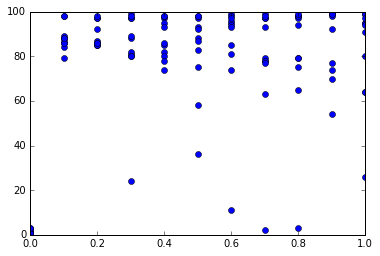

In [7]:
# Learning rate vs # successes
plt.plot(learning_rates, successes, "o")

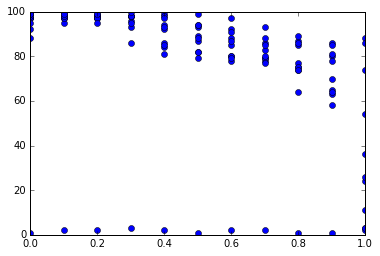

In [8]:
# Discount rate vs # successes
plt.plot(discount_rates, successes, "o")

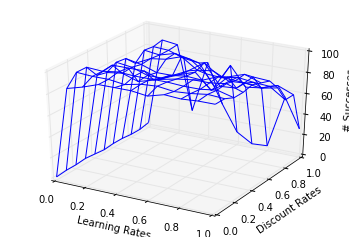

In [44]:
# Rates vs # successes
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs = [[i/10.0 for j in range(11)] for i in range(11)]
ys = [[j/10.0 for j in range(11)] for i in range(11)]
zs = [successes[i*11:((i+1)*11)] for i in range(11)]

ax.plot_wireframe(xs, ys, zs)


ax.set_xlabel('Learning Rates')
ax.set_ylabel('Discount Rates')
ax.set_zlabel('# Successes')

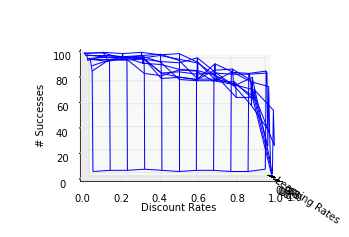

In [64]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(0, 0)
ax.plot_wireframe(xs, ys, zs)
ax.set_xlabel('Learning Rates')
ax.set_ylabel('Discount Rates')
ax.set_zlabel('# Successes')

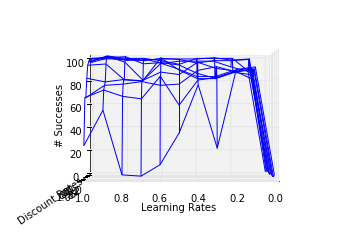

In [65]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(0, 90)
ax.plot_wireframe(xs, ys, zs)
ax.set_xlabel('Learning Rates')
ax.set_ylabel('Discount Rates')
ax.set_zlabel('# Successes')

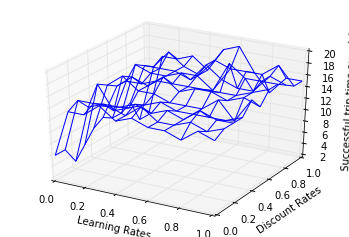

In [66]:
# Rates vs # successes
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs = [[i/10.0 for j in range(11)] for i in range(11)]
ys = [[j/10.0 for j in range(11)] for i in range(11)]
zs = [success_times[i*11:((i+1)*11)] for i in range(11)]

ax.plot_wireframe(xs, ys, zs)


ax.set_xlabel('Learning Rates')
ax.set_ylabel('Discount Rates')
ax.set_zlabel('Successful trip time avg. (s)')

## Question 6

> QUESTION: Does your agent get close to finding an optimal policy, i.e. reach the destination in the minimum possible time, and not incur any penalties? How would you describe an optimal policy for this problem?

I think it gets close, because the best average trip times look to be about 10s, and the learner gets such a high success rate that it often learns close to the optimal policy in its first trip. I'm guessing this is because rewards from following the trip planner is a really basic way to give immediate feedback for the end payoff. If they weren't so perfectly linked, the discount rate may be higher in the optimal policy. 

It does, however, still incur penalties, even at the end of the trials. In the last 10 runs, the learner gets 8 negative rewards:

```
Errored in state: left,True,True,False,red action: left
Errored in state: left,True,True,True,red action: right
Errored in state: forward,True,True,True,red action: forward
Errored in state: forward,True,True,True,red action: left
Errored in state: forward,True,True,True,red action: forward
Errored in state: left,True,True,False,green action: right
Errored in state: right,True,False,True,green action: forward
Errored in state: forward,oncomingblocking,True,True,red action: forward
```

These errors are all rarely-encountered states - each boolean represents a car at some position in the intersection, and all of these states have at least two other cars at the intersection (which is rare).


The optimal policy is go in the direct the route planner recommends, but stay still when going in that direction will incur penalties - straight or left at a red, right at red when a car is at left, left at green when a car is at forward. 